In [ ]:
from mainnet_launch.database.schema.ensure_tables_are_current.using_onchain.not_order_dependent.about_incentives.update_destination_vault_balance_updated import *
from mainnet_launch.constants import *
from mainnet_launch.database.postgres_operations import (
    get_full_table_as_df_with_tx_hash,
    get_full_table_as_df_with_block,
)
from mainnet_launch.database.schema.full import (
    Blocks,
    IncentiveTokenBalanceUpdated,
    Tokens,
    DestinationStates,
    AutopoolDestinationStates,
    AutopoolDestinations,
)
import plotly.express as px
import plotly.io as pio
import pandas as pd

pio.templates.default = "plotly_white"


def augment_claimed_events(claimed: pd.DataFrame) -> pd.DataFrame:
    claimed = claimed.copy()
    claimed["symbol"] = claimed["destination_symbol"] + " - " + claimed["token_symbol"]
    claimed["block_timestamp"] = pd.to_datetime(claimed.index, utc=True)
    claimed = claimed.sort_values(["symbol", "block_timestamp"])
    claimed["hours_between"] = claimed.groupby("symbol")["block_timestamp"].diff().dt.total_seconds() / 3600.0

    return claimed


def fetch_incentive_token_claimed_data():
    a_week_ago = pd.Timestamp.now(tz="utc") - pd.Timedelta(days=7)
    where_clause = Blocks.datetime > a_week_ago

    # todo these reads can be parallelized, and only specific columns selected
    claimed = get_full_table_as_df_with_tx_hash(IncentiveTokenBalanceUpdated)
    destinations = get_full_table_as_df(Destinations)
    tokens = get_full_table_as_df(Tokens)
    destination_states = get_full_table_as_df_with_block(DestinationStates, where_clause=where_clause)
    autopool_states = get_full_table_as_df_with_block(AutopoolDestinationStates, where_clause=where_clause)
    autopool_destinations = get_full_table_as_df(AutopoolDestinations)

    destination_vault_address_to_symbol = dict(
        zip(destinations["destination_vault_address"], destinations["underlying_name"])
    )
    token_address_to_symbol = dict(zip(tokens["token_address"], tokens["symbol"]))
    autopool_vault_address_to_symbol = {a.autopool_eth_addr: a.name for a in ALL_AUTOPOOLS}

    claimed["destination_symbol"] = claimed["destination_vault_address"].map(destination_vault_address_to_symbol)
    claimed["token_symbol"] = claimed["token_address"].map(token_address_to_symbol)

    destination_states["destination_symbol"] = destination_states["destination_vault_address"].map(
        destination_vault_address_to_symbol
    )

    autopool_states["destination_symbol"] = autopool_states["destination_vault_address"].map(
        destination_vault_address_to_symbol
    )
    autopool_states["autopool_name"] = autopool_states["autopool_vault_address"].map(autopool_vault_address_to_symbol)

    autopool_destinations["destination_symbol"] = autopool_destinations["destination_vault_address"].map(
        destination_vault_address_to_symbol
    )
    autopool_destinations["autopool_name"] = autopool_destinations["autopool_vault_address"].map(
        autopool_vault_address_to_symbol
    )

    claimed = augment_claimed_events(claimed)
    return claimed, destination_states, autopool_states, autopool_destinations


claimed, destination_states, autopool_states, autopool_destinations = fetch_incentive_token_claimed_data()


def identify_suspect_destinations() -> pd.DataFrame:
    """

    A destination is suspect if:
        - We owne >0 shares any point in last week
        - We showed a >0 incentive APR any point in last week
        - The liquidation row has not emitted a balanceUpdated event in last 3 days for that destination

    """
    three_days_ago = pd.Timestamp.now(tz="utc") - pd.Timedelta(days=3)
    recently_claimed_destinations = claimed[claimed.index > three_days_ago]["destination_vault_address"].unique()
    destinations_with_some_shares = (
        autopool_states.groupby("destination_vault_address")["owned_shares"].max().loc[lambda x: x > 0].index
    )
    destinations_with_some_incentive_apr = (
        destination_states.groupby("destination_vault_address")["incentive_apr"].max().loc[lambda x: x > 0].index
    )

    destinations_with_some_incentive_apr_and_owned_shares = [
        s for s in destinations_with_some_incentive_apr if s in destinations_with_some_shares
    ]
    expected_but_not_claimed = [
        s for s in destinations_with_some_incentive_apr_and_owned_shares if s not in recently_claimed_destinations
    ]

    suspect_destinations = autopool_destinations[
        autopool_destinations["destination_vault_address"].isin(expected_but_not_claimed)
    ]

    # Add the highest recent incentive APR to the suspect destinations
    suspect_destinations = suspect_destinations.merge(
        destination_states.groupby("destination_vault_address")["incentive_apr"]
        .max()
        .rename("highest_recent_incentive_apr")
        * 100,
        on="destination_vault_address",
        how="left",
    )

    most_owned_shares = (
        autopool_states.groupby("destination_vault_address")["owned_shares"].max().rename("most_owned_shares")
    )
    suspect_destinations = suspect_destinations.merge(most_owned_shares, on="destination_vault_address", how="left")

    most_recent_claimed = (
        claimed.groupby("destination_vault_address")["block_timestamp"].max().rename("most_recent_claimed")
    )
    suspect_destinations = suspect_destinations.merge(most_recent_claimed, on="destination_vault_address", how="left")

    most_recent_claimed["hours_since_claim"] = (
        pd.Timestamp.now(tz="utc") - suspect_destinations["most_recent_claimed"]
    ).dt.total_seconds() / 3600.0

    cols = [
        "destination_vault_address",
        "destination_symbol",
        "autopool_name",
        "highest_recent_incentive_apr",
        "most_owned_shares",
        "hours_since_claim",
    ]

    return suspect_destinations[cols].round(4)

In [11]:
suspect_destinations.columns

Index(['destination_vault_address', 'chain_id', 'autopool_vault_address',
       'destination_symbol', 'autopool_name', 'highest_recent_incentive_apr',
       'most_owned_shares', 'most_recent_claimed'],
      dtype='object')

,destination_vault_address,destination_symbol,autopool_name,highest_recent_incentive_apr,most_owned_shares,most_recent_claimed
0,0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61,Fluid Tether USD,autoUSD,1.9700,2.047712e+05,2025-11-01 07:02:11+00:00
1,0xd3a721711b41c4f22C22A0727853fE322B84e931,Steakhouse USDC,baseUSD,1.6450,1.314058e+05,2025-11-02 18:55:59+00:00
2,0x4eeDC6d6126ae9C6D92D03bB355eEAe5E47d2b03,Gauntlet USDC Prime,baseUSD,0.3361,1.100173e+07,2025-11-19 18:55:35+00:00
3,0xCc68b840Bd7567363855e1e5050803EC7Ea8C25c,Gauntlet USDC Core,baseUSD,0.3361,5.400693e+06,2025-11-19 18:55:35+00:00
4,0x16cbe611AF0E01ec6988b59aD3690327aD496Eb7,Seamless USDC Vault,baseUSD,0.7222,4.792375e+06,2025-11-19 18:55:35+00:00
5,0xFd70A9b4cE03Dc07Fe7Ba5e4D39fac11eE8d8615,Moonwell Flagship USDC,baseUSD,1.1642,1.120614e+06,2025-11-19 18:55:35+00:00
6,0xFf004bA7Df7F0D4fD0D1856f009184bd77A24192,Gauntlet USDC Prime,arbUSD,1.3656,3.572042e+06,2025-11-19 21:37:11+00:00
7,0xab3DA8995D5FeA17913c3D12A5B199F1cCC9Bf0b,Steakhouse High Yield USDC,arbUSD,1.4984,3.607435e+06,2025-11-19 21:37:11+00:00
8,0x5DD8e6C497d350aE7A32d6e2DFc07F42B27F905B,Fluid USDT0,plasmaUSD,4.5100,1.073428e+06,2025-11-19 22:49:56+00:00


In [ ]:
suspect_destinations

In [ ]:
px.scatter(
    claimed[claimed["destination_vault_address"] == "0x5DD8e6C497d350aE7A32d6e2DFc07F42B27F905B"],
    x="block_timestamp",
    y="new_balance",
)

In [ ]:
claimed.columns

Index(['tx_hash', 'log_index', 'chain_id', 'liquidation_row', 'token_address',
       'destination_vault_address', 'new_balance', 'block',
       'destination_symbol', 'token_symbol', 'symbol', 'block_timestamp',
       'hours_between'],
      dtype='object')

In [ ]:
# EOA rabby fUSDC recent claimed
claimed[claimed["destination_vault_address"] == "0x7876F91BB22148345b3De16af9448081E9853830"].sort_index(
    ascending=False
)

,tx_hash,log_index,chain_id,liquidation_row,token_address,destination_vault_address,new_balance,block,destination_symbol,token_symbol,symbol,block_timestamp,hours_between
datetime,,,,,,,,,,,,,
2025-12-02 07:01:47+00:00,0x2b4fa4eb4f25147a590e28b4abd1824ffbee919012b9...,1110,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,78.746274,23924163,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-12-02 07:01:47+00:00,23.990000
2025-12-01 07:02:23+00:00,0x0270e04e41f2e26d05d6f84cc193cfc8c09f1c2b1ce9...,1190,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,80.914889,23917014,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-12-01 07:02:23+00:00,23.013333
2025-11-30 08:01:35+00:00,0x22e089d2f8151beafbef5cd977ec9c0917924835b7b0...,855,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,81.962657,23910151,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-11-30 08:01:35+00:00,24.996667
2025-11-29 07:01:47+00:00,0xfdc494c28c5a9d26a859565bf5ac7157d51951c43660...,643,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,82.165210,23902698,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-11-29 07:01:47+00:00,23.003333
2025-11-28 08:01:35+00:00,0x5f6c173d908c98c765ec41af1f043cedc19332468a5e...,1172,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,34.430501,23895853,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-11-28 08:01:35+00:00,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-06 00:09:35+00:00,0x2bdb970a34b7c0273a64b1a9c74ec26842e96c0af8f6...,390,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,83.594545,22421014,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-05-06 00:09:35+00:00,27.996667
2025-05-04 20:09:47+00:00,0x6147401a792f674fb22115d135d952d8a0877d06cb84...,436,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,80.063488,22412684,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-05-04 20:09:47+00:00,21.033333
2025-05-03 23:07:47+00:00,0x70db3e513cca6313aaecaccc398b293786e9fc4318df...,555,1,0xF570EA70106B8e109222297f9a90dA477658d481,0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb,0x7876F91BB22148345b3De16af9448081E9853830,51.242629,22406436,Fluid USD Coin,FLUID,Fluid USD Coin - FLUID,2025-05-03 23:07:47+00:00,20.993333


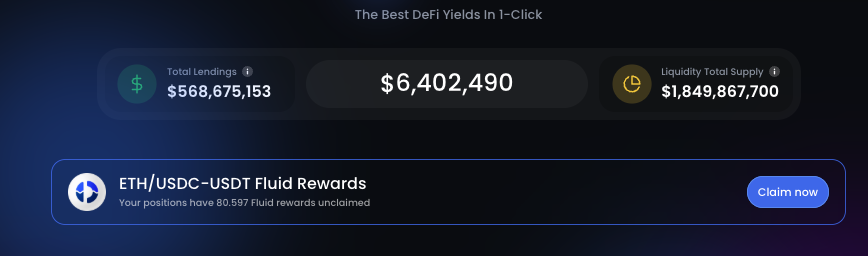

rabby as the fUSDC destination vault it shows there is fluid to claim, but not fUSDT to claim, when doing it as that EOA

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## some new methods to try and catch this

True positive,
- We should have moved some rewards but did not. Urgent, need to fix
False positive 
- "Warning! we should have move some rewards but did not", 
- - False becuase we have moved rewards
- - Flase bacause there are no rewards to move


True Negative
- For X destination vault, we have claimed incentive tokens within the last 24 hours,
- - We have not claimed and we shoul dnot have claimed
- - we have claimed and we should have claimed|

- stipulations, missing a true positive is bad

In [ ]:
from datetime import datetime, timedelta, timezone

# Get the current time
now = datetime.now(timezone.utc)

# Calculate the threshold time (24 hours ago)
threshold_time = now - timedelta(hours=48)

# Group by symbol and find the max datetime_claimed
last_claimed = df.groupby("symbol")["datetime_claimed"].max()
symbols_over_24_hours = last_claimed[last_claimed < threshold_time].index.tolist()


suspect_df = df[df["symbol"].isin(symbols_over_24_hours)]
px.scatter(
    suspect_df,
    x=suspect_df.index,
    y="hours_between",
    color="symbol",
    hover_data=["new_balance"],
    title="Destination Vault Balances Over Time (Suspect)",
)

# Filter symbols where the max datetime_claimed is more than 24 hours ago
print(len(symbols_over_24_hours), "symbols have not claimed incentives in the last 48 hours:")

NameError: name 'symbols_claimed_voe' is not defined

In [ ]:
# my code to catch destination vaults not getting liquidated properly; failed to catch this

fluid_destinations = [
    "0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61",
    "0x28d2F508127B0617Ded8243836eB7b5787828648",
    "0x7876F91BB22148345b3De16af9448081E9853830",
]
sub_df = df[df["destination_vault_address"].isin(fluid_destinations)].copy()

sub_df = sub_df.sort_index()


px.scatter

array(['0x6f40d4A6237C257fff2dB00FA0510DeEECd303eb'], dtype=object)

In [ ]:
px.scatter(
    sub_df,
    x=sub_df.index,
    y="hours_between",
    color="symbol",
    hover_data=["new_balance"],
    title="Destination Vault Balances Over Time (Suspect)",
).show()

In [ ]:
sub_df

In [ ]:
# there was a gap in claiming incentives between nov 20 and nov 27 for fluid USDC
#  incentive apr was > 1% () we had some money there, and there should have been expected incentives claimed but instead there were not

In [ ]:
# destination_vault_address	symbol	pool	underlying_name
# 1	0xE4545f9dBC30Ccb6Cda6930DDFd69f3D419FcB61	toke-USDC-fUSDT	0x5C20B550819128074FD538Edf79791733ccEdd18	Fluid Tether USD
# 2	0x28d2F508127B0617Ded8243836eB7b5787828648	toke-USDC-fsUSDS	0x2BBE31d63E6813E3AC858C04dae43FB2a72B0D11	Fluid Savings USDS
# 3	0x7876F91BB22148345b3De16af9448081E9853830	toke-USDC-fUSDC	0x9Fb7b4477576Fe5B32be4C1843aFB1e55F251B33	Fluid USD Coin